In [1]:
!pip install hmmlearn

     |████████████████████████████████| 374 kB 5.1 MB/s 


In [2]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

PLOT_SHOW=True
PLOT_TYPE = False


K = 50
NUM_ITERS=10000

In [3]:
#STOCKS=['apple.csv','cmcst.csv','google.csv','qcom.csv']
#NUM_STATES=12
#FILE_NAME='HistoricalQuotes.csv'
#TRAIN_CHUNK_SIZE=100

#dirichlet_params = np.array([1., 20., 20., 20.])
#dirichlet_params = np.random.randint(1,50,NUM_STATES)
labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(2,20)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DA2/

Mounted at /content/drive
/content/drive/MyDrive/DA2


In [5]:
import pandas as pd
ab = pd.read_csv('BTC-USD.csv')
ab.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,8/8/2015,279.742004,279.928009,260.709991,260.997009,260.997009,58533000.0,-0.066484
1,8/9/2015,261.115997,267.002991,260.467987,265.083008,265.083008,23789600.0,0.015655
2,8/10/2015,265.477997,267.032013,262.596008,264.470001,264.470001,20979400.0,-0.002313
3,8/11/2015,264.342010,270.385986,264.093994,270.385986,270.385986,25433900.0,0.022369
4,8/12/2015,270.597992,270.673004,265.468994,266.376007,266.376007,26815400.0,-0.014831
5,8/13/2015,266.183014,266.231995,262.841003,264.079987,264.079987,27685500.0,-0.008619
6,8/14/2015,264.131989,267.466003,261.477997,265.679993,265.679993,27091200.0,0.006059
7,8/15/2015,265.528992,266.666992,261.295990,261.550995,261.550995,19321100.0,-0.015541
8,8/16/2015,261.865997,262.440002,257.040985,258.506989,258.506989,29717000.0,-0.011638
9,8/17/2015,258.489990,260.505005,257.117004,257.976013,257.976013,21617900.0,-0.002054


In [6]:
data_hmm = ab.iloc[500:,1:5].values
print(data_hmm.shape)
print(data_hmm[1:5,1:2])
#NUM_TEST = 400
NUM_TOTAL = data_hmm.shape[0]
print(NUM_TOTAL)
NUM_TEST = 90
NUM_TRAIN = NUM_TOTAL - NUM_TEST


(1776, 4)
[[834.281006]
 [875.781982]
 [925.117004]
 [923.479004]]
1776


In [7]:
stock = data_hmm
dataset = data_hmm[:NUM_TRAIN,3]
dataset = np.reshape(dataset, (-1,1))
dataset = np.flipud(dataset)

likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])
for states in STATE_SPACE:
    num_params = states**2 + states
    dirichlet_params_states = np.random.randint(1,50,states)
    #model = hmm.GaussianHMM(n_components=states, covariance_type='full', startprob_prior=dirichlet_params_states, transmat_prior=dirichlet_params_states, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
    model.fit(dataset)
    
    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
    bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))

opt_states = np.argmin(bic_vect) + 2
print('Optimum number of states are {}'.format(opt_states))

Optimum number of states are 9


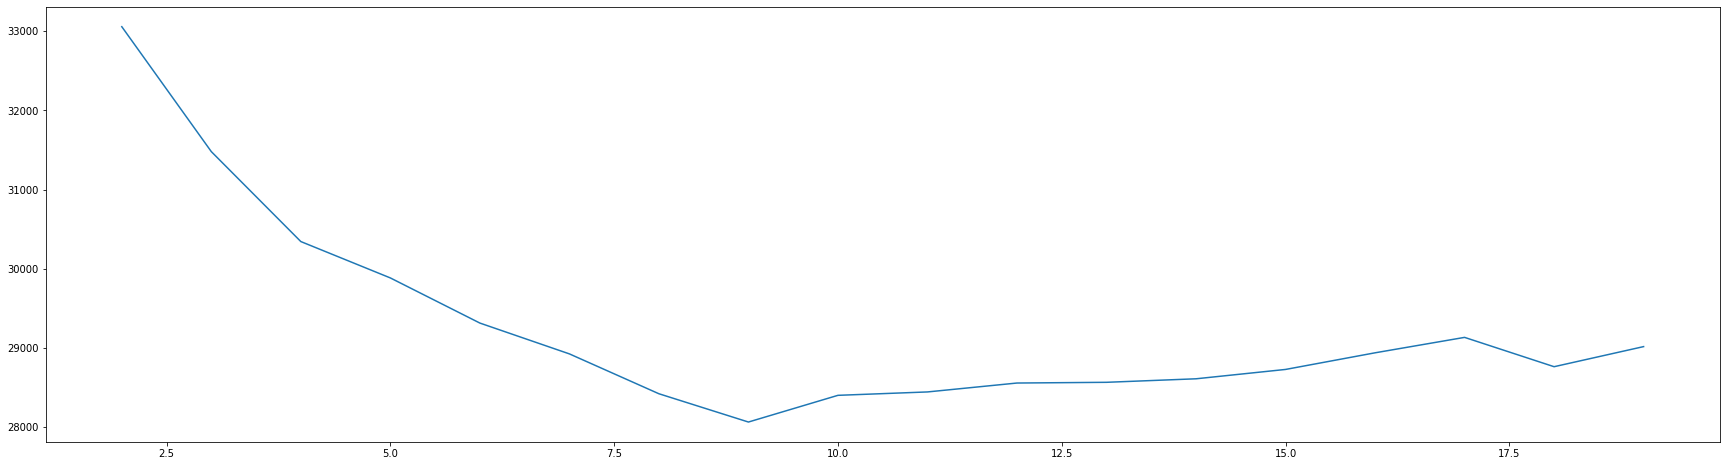

In [8]:
plt.figure(figsize = (30,8))
plt.plot(STATE_SPACE, bic_vect)

In [ ]:
print(dataset.shape)

(1777, 0)


In [9]:
predicted_stock_data = np.empty([0,dataset.shape[1]])
for idx in reversed(range(NUM_TEST)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
    else:
        # Retune the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior

    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    #print('Model score : ', model.score(dataset))
    #print('Dirichlet parameters : ',dirichlet_params)

    iters = 1;
    past_likelihood = []
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    # print(likelihood_diff_idx)
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
#np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

# mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(NUM_TEST),:]))
# print('MAPE for the Ethereum {} is '.format(stock),mape)


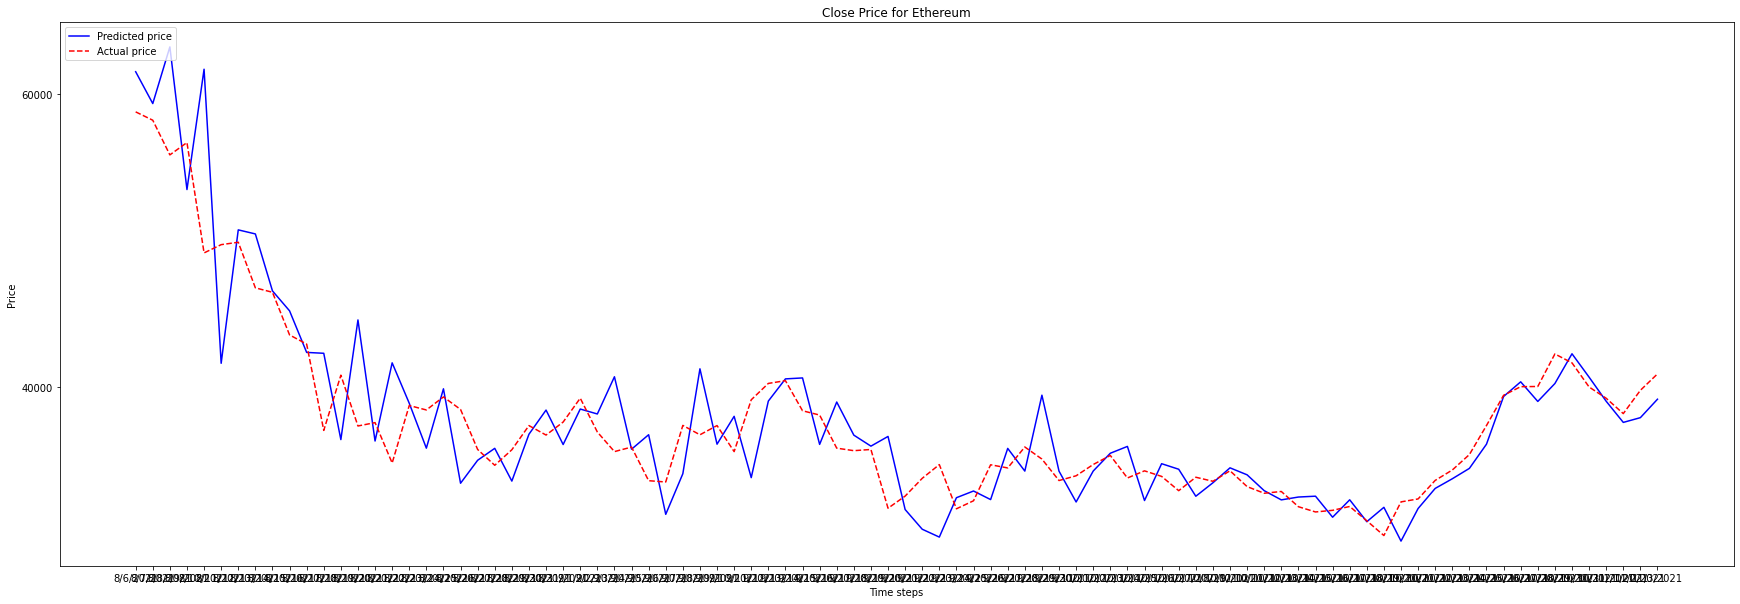

In [10]:
i=0
plt.figure(figsize=(30,10))
#plt.figure()
plt.plot(ab.loc[500+NUM_TRAIN:, 'Date'], predicted_stock_data[:,i],'b-', label = 'Predicted price');
plt.plot(ab.loc[500+NUM_TRAIN:, 'Date'], np.flipud(dataset[range(NUM_TEST),i]),'r--', label = 'Actual price')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('Close Price for Ethereum')
plt.grid(False)
plt.legend(loc = 'upper left')
plt.locator_params(axis='y', nbins=2)
plt.show()

In [11]:
pre_value = predicted_stock_data[:,i]
real_value = np.flipud(dataset[range(NUM_TEST),i])

import math

MAPE = np.abs(pre_value - real_value)
RMSE = np.multiply(MAPE,MAPE)
RMSE = math.sqrt(np.mean(RMSE))/np.mean(real_value)
MAE = np.mean(MAPE)/np.mean(real_value)
MAPE = np.divide(MAPE,real_value)
MAPE = np.mean(MAPE)
print('MAPE = ',MAPE)
print('MAE = ', MAE*100, '%')
print('RMSE = ',RMSE*100, '%')

MAPE =  0.052448945991141034
MAE =  5.363509802694019 %
RMSE =  7.8304815327632395 %
